In [38]:
import pandas as pd
import numpy as np
from pycaret.regression import *
from scipy import stats
import matplotlib.pyplot as plt
# Load your dataset
df = pd.read_csv("data_preprocess\export-pm25_eng-1h.csv", parse_dates=["timestamp"], index_col="timestamp")
df = df.sort_values(by="timestamp")
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['day'] = df.index.day
df.head()


,Unnamed: 0,timezone,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,dayofweek,month,day
timestamp,,,,,,,,,,
2023-03-31 22:00:00,0,Asia/Bangkok,62.659563,4.727273,4.727273,4.727273,27.147784,4,3,31
2023-04-02 18:00:00,1,Asia/Bangkok,69.995698,7.857143,7.142857,7.142857,32.246966,6,4,2
2023-04-02 19:00:00,2,Asia/Bangkok,65.608215,8.400000,7.800000,7.800000,32.518829,6,4,2
2023-04-02 20:00:00,3,Asia/Bangkok,65.489705,8.750000,8.266667,8.266667,31.864227,6,4,2
2023-04-02 21:00:00,4,Asia/Bangkok,65.811462,10.316667,9.083333,9.083333,31.412888,6,4,2


In [39]:
Q1_pm = df['pm_2_5'].quantile(0.25)
Q3_pm = df['pm_2_5'].quantile(0.75)
IQR_pm = Q3_pm - Q1_pm

Q1_temp = df['temperature'].quantile(0.25)
Q3_temp = df['temperature'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp

df = df[(df['pm_2_5'] >= Q1_pm - 1.5 * IQR_pm) & (df['pm_2_5'] <= Q3_pm + 1.5 * IQR_pm)]
df = df[(df['temperature'] >= Q1_temp - 1.5 * IQR_temp) & (df['temperature'] <= Q3_temp + 1.5 * IQR_temp)]
df

,Unnamed: 0,timezone,humidity,pm_10,pm_2_5,pm_2_5_sp,temperature,dayofweek,month,day
timestamp,,,,,,,,,,
2023-03-31 22:00:00,0,Asia/Bangkok,62.659563,4.727273,4.727273,4.727273,27.147784,4,3,31
2023-04-02 18:00:00,1,Asia/Bangkok,69.995698,7.857143,7.142857,7.142857,32.246966,6,4,2
2023-04-02 19:00:00,2,Asia/Bangkok,65.608215,8.400000,7.800000,7.800000,32.518829,6,4,2
2023-04-02 20:00:00,3,Asia/Bangkok,65.489705,8.750000,8.266667,8.266667,31.864227,6,4,2
2023-04-02 21:00:00,4,Asia/Bangkok,65.811462,10.316667,9.083333,9.083333,31.412888,6,4,2
...,...,...,...,...,...,...,...,...,...,...
2025-02-11 08:00:00,14791,Asia/Bangkok,90.929747,42.294118,37.568627,36.882353,23.684319,1,2,11
2025-02-11 09:00:00,14792,Asia/Bangkok,83.511569,42.916667,38.800000,41.166667,25.896389,1,2,11
2025-02-11 10:00:00,14793,Asia/Bangkok,72.046736,27.533333,23.333333,19.466667,28.852626,1,2,11


In [41]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df[f'pm_2_5_lag_{lag}'] = df['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df = df.drop(columns=["Unnamed: 0", "timezone", "pm_2_5_sp", 'pm_10'], axis=1)
df.dropna(inplace=True)
df

,humidity,pm_2_5,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,,,,,,
2023-04-03 00:00:00,66.876119,7.200000,30.042084,0,4,3,7.466667,9.366667,9.083333,8.266667,7.800000,7.142857,4.727273
2023-04-03 01:00:00,67.430725,7.783333,29.392181,0,4,3,7.200000,7.466667,9.366667,9.083333,8.266667,7.800000,7.142857
2023-04-03 02:00:00,68.017985,16.500000,29.118591,0,4,3,7.783333,7.200000,7.466667,9.366667,9.083333,8.266667,7.800000
2023-04-03 03:00:00,68.853455,24.783333,28.612701,0,4,3,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,8.266667
2023-04-03 04:00:00,69.691119,28.543860,28.313422,0,4,3,24.783333,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11 08:00:00,90.929747,37.568627,23.684319,1,2,11,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416667
2025-02-11 09:00:00,83.511569,38.800000,25.896389,1,2,11,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932
2025-02-11 10:00:00,72.046736,23.333333,28.852626,1,2,11,38.800000,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333


In [42]:
compare_data = df[-7:]  # Last 7 known values
compare_data
df = df[:-7]
compare_data

,humidity,pm_2_5,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,,,,,,
2025-02-10 21:00:00,77.279939,28.533333,26.323620,0,2,10,28.383333,28.883333,27.033333,26.355932,25.416667,25.450000,25.183333
2025-02-10 22:00:00,78.573505,31.325581,26.209783,0,2,10,28.533333,28.383333,28.883333,27.033333,26.355932,25.416667,25.450000
2025-02-11 08:00:00,90.929747,37.568627,23.684319,1,2,11,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416667
2025-02-11 09:00:00,83.511569,38.800000,25.896389,1,2,11,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932
2025-02-11 10:00:00,72.046736,23.333333,28.852626,1,2,11,38.800000,37.568627,31.325581,28.533333,28.383333,28.883333,27.033333
2025-02-11 11:00:00,64.332405,21.850000,30.593716,1,2,11,23.333333,38.800000,37.568627,31.325581,28.533333,28.383333,28.883333
2025-02-11 11:15:36,61.046112,21.000000,31.861472,1,2,11,21.850000,23.333333,38.800000,37.568627,31.325581,28.533333,28.383333


In [43]:
exp = setup(data=df, target='pm_2_5', fold=10, session_id=123, iterative_imputation_iters=100, remove_outliers = True, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(13702, 13)"
4,Transformed data shape,"(13222, 13)"
5,Transformed train set shape,"(9111, 13)"
6,Transformed test set shape,"(4111, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [44]:
best_model = exp.compare_models()  # Find the best regression model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,3.4265,25.7818,5.0698,0.8313,0.2879,0.2508,2.3760
lightgbm,Light Gradient Boosting Machine,3.4275,25.8178,5.0743,0.8311,0.2875,0.2465,1.4040
et,Extra Trees Regressor,3.4948,26.8106,5.1718,0.8245,0.2931,0.2548,0.6650
lr,Linear Regression,3.4629,27.0024,5.1890,0.8234,0.2951,0.2576,0.2210
ridge,Ridge Regression,3.4629,27.0024,5.1890,0.8234,0.2951,0.2576,0.2000
br,Bayesian Ridge,3.4632,27.0022,5.1890,0.8234,0.2951,0.2577,0.2780
rf,Random Forest Regressor,3.5084,27.0975,5.1988,0.8228,0.2949,0.2551,1.9560
lar,Least Angle Regression,3.4700,27.1618,5.2035,0.8223,0.2961,0.2580,0.2880
en,Elastic Net,3.4807,27.2811,5.2158,0.8215,0.2951,0.2610,0.2310
lasso,Lasso Regression,3.4978,27.6478,5.2508,0.8191,0.2961,0.2628,0.2080


In [45]:
best_model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.4849,26.1878,5.1174,0.8232,0.2981,0.2636
1,3.6457,30.7205,5.5426,0.8087,0.3114,0.2743
2,3.2764,22.4438,4.7375,0.8490,0.2763,0.2378
3,3.5932,27.8859,5.2807,0.8139,0.2877,0.2460
4,3.3080,23.2482,4.8216,0.8365,0.2763,0.2371
5,3.5537,28.8422,5.3705,0.8123,0.2990,0.2469
6,3.2337,23.2539,4.8222,0.8455,0.2731,0.2188
7,3.3879,24.0531,4.9044,0.8443,0.2826,0.2498
8,3.3489,23.7960,4.8781,0.8588,0.2707,0.2320


In [46]:
exp.predict_model(best_model,data=df)  # Train the best model on the entire dataset

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.9973,19.6499,4.4328,0.8715,0.2574,0.2163


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2023-04-03 00:00:00,66.876122,30.042084,0,4,3,7.466667,9.366667,9.083333,8.266666,7.800000,7.142857,4.727273,7.200000,8.559269
2023-04-03 01:00:00,67.430725,29.392181,0,4,3,7.200000,7.466667,9.366667,9.083333,8.266666,7.800000,7.142857,7.783333,8.738662
2023-04-03 02:00:00,68.017982,29.118591,0,4,3,7.783333,7.200000,7.466667,9.366667,9.083333,8.266666,7.800000,16.500000,10.253702
2023-04-03 03:00:00,68.853455,28.612701,0,4,3,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,8.266666,24.783333,20.116516
2023-04-03 04:00:00,69.691116,28.313421,0,4,3,24.783333,16.500000,7.783333,7.200000,7.466667,9.366667,9.083333,28.543859,23.430984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10 16:00:00,63.063889,30.294567,0,2,10,25.450001,25.183332,25.016666,26.033333,26.650000,26.810345,28.666666,25.416666,25.483734
2025-02-10 17:00:00,66.199043,29.137453,0,2,10,25.416666,25.450001,25.183332,25.016666,26.033333,26.650000,26.810345,26.355932,26.938321
2025-02-10 18:00:00,68.488899,28.289711,0,2,10,26.355932,25.416666,25.450001,25.183332,25.016666,26.033333,26.650000,27.033333,26.944272


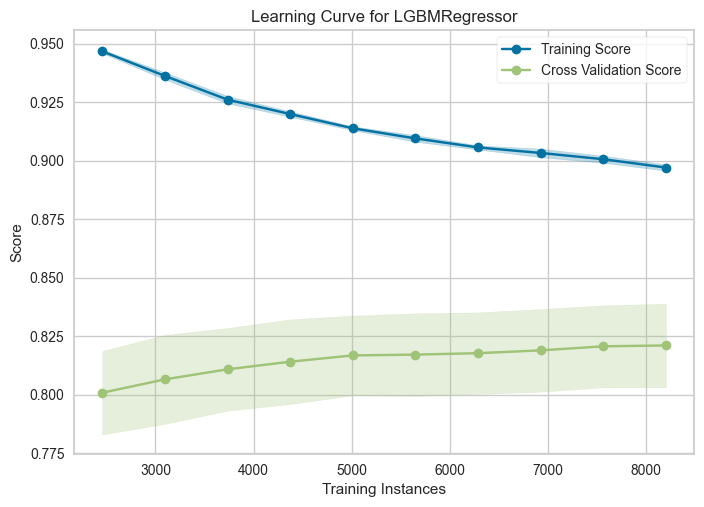

In [47]:
exp.plot_model(best_model, plot='learning')

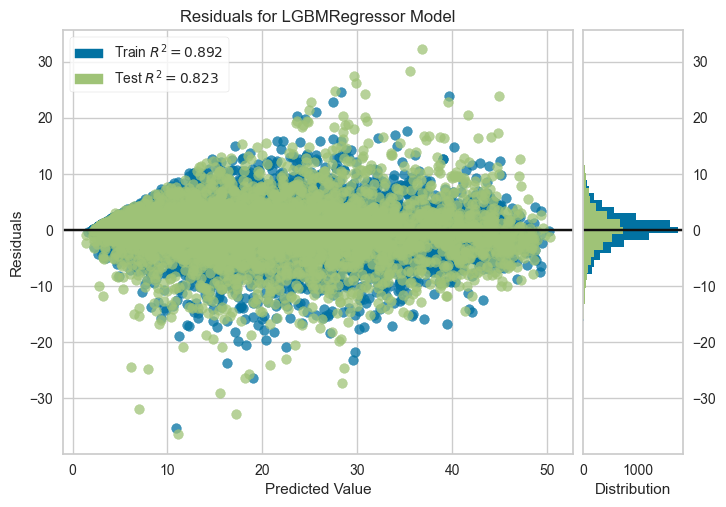

In [48]:
exp.plot_model(best_model)

In [49]:
# Get the last row (most recent data point)
latest_data = df.iloc[-1:].copy()

# Shift lag features forward by 1 day
for lag in range(1, 8):
    latest_data[f'pm_2_5_lag_{lag}'] = df['pm_2_5'].iloc[-lag]

# Make predictions
future_pred = exp.predict_model(best_model, data=latest_data)
future_pred

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0128,0.0002,0.0128,nan,0.0004,0.0005


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2025-02-10 20:00:00,76.134628,26.503902,0,2,10,28.383333,28.883333,27.033333,26.355932,25.416666,25.450001,25.183332,28.383333,28.396139


**Test with other Data**

In [50]:
df_test = pd.read_csv("data_preprocess\clean_data\songkla_concat_data.csv", parse_dates=["timestamp"], index_col="timestamp")
df_test = df_test.sort_values(by="timestamp")
df_test = df_test.groupby(['timestamp'], as_index=True).agg({'humidity': 'mean','pm_2_5': 'mean','temperature': 'mean'})
df_test['dayofweek'] = df_test.index.dayofweek
df_test['month'] = df_test.index.month
df_test['day'] = df_test.index.day

In [51]:
Q1_pm = df_test['pm_2_5'].quantile(0.25)
Q3_pm = df_test['pm_2_5'].quantile(0.75)
IQR_pm = Q3_pm - Q1_pm

Q1_temp = df_test['temperature'].quantile(0.25)
Q3_temp = df_test['temperature'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp

df_test = df_test[(df_test['pm_2_5'] >= Q1_pm - 1.5 * IQR_pm) & (df_test['pm_2_5'] <= Q3_pm + 1.5 * IQR_pm)]
df_test = df_test[(df_test['temperature'] >= Q1_temp - 1.5 * IQR_temp) & (df_test['temperature'] <= Q3_temp + 1.5 * IQR_temp)]
df_test

,humidity,pm_2_5,temperature,dayofweek,month,day
timestamp,,,,,,
2021-12-01 14:00:00,66.269500,2.000000,24.990000,2,12,1
2021-12-01 15:00:00,60.997426,0.815789,25.950526,2,12,1
2021-12-01 16:00:00,61.093943,1.083333,26.178000,2,12,1
2021-12-01 17:00:00,61.953554,1.098361,26.292459,2,12,1
2021-12-01 18:00:00,61.932943,1.133333,26.525667,2,12,1
...,...,...,...,...,...,...
2025-02-11 11:00:00,62.084135,21.138544,30.818872,1,2,11
2025-02-11 11:12:18,52.840677,31.750000,32.533843,1,2,11
2025-02-11 11:12:43,59.010000,12.920000,31.300000,1,2,11


In [52]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df_test[f'pm_2_5_lag_{lag}'] = df_test['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df_test.dropna(inplace=True)

In [53]:
predict_df_test = exp.predict_model(best_model, data=df_test)
predict_df_test

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8909,16.4888,4.0606,0.8655,0.2377,0.2086


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2021-12-01 21:00:00,63.084160,26.532200,2,12,1,1.278689,1.131148,1.133333,1.098361,1.083333,0.815789,2.000000,1.000000,2.870137
2021-12-01 22:00:00,63.969959,26.450001,2,12,1,1.000000,1.278689,1.131148,1.133333,1.098361,1.083333,0.815789,1.000000,2.851827
2021-12-01 23:00:00,63.085220,27.644194,2,12,1,1.000000,1.000000,1.278689,1.131148,1.133333,1.098361,1.083333,1.000000,3.079691
2021-12-02 00:00:00,62.688133,28.375750,3,12,2,1.000000,1.000000,1.000000,1.278689,1.131148,1.133333,1.098361,1.100000,3.056256
2021-12-02 01:00:00,63.037460,28.659153,3,12,2,1.100000,1.000000,1.000000,1.000000,1.278689,1.131148,1.133333,1.406780,2.910458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11 11:00:00,62.084137,30.818872,1,2,11,24.755386,38.988914,40.896278,36.896111,33.914726,35.262779,37.392918,21.138544,21.767333
2025-02-11 11:12:18,52.840675,32.533844,1,2,11,21.138544,24.755386,38.988914,40.896278,36.896111,33.914726,35.262779,31.750000,21.092825
2025-02-11 11:12:43,59.009998,31.299999,1,2,11,31.750000,21.138544,24.755386,38.988914,40.896278,36.896111,33.914726,12.920000,32.106933


In [54]:
# Predict on a test set (known values)
test_predictions2 = exp.predict_model(best_model, data=compare_data)  # Last 7 known values
test_predictions2

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.1265,31.9414,5.6517,0.3062,0.1818,0.1218


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2025-02-10 21:00:00,77.279938,26.323620,0,2,10,28.383333,28.883333,27.033333,26.355932,25.416666,25.450001,25.183332,28.533333,28.396139
2025-02-10 22:00:00,78.573502,26.209784,0,2,10,28.533333,28.383333,28.883333,27.033333,26.355932,25.416666,25.450001,31.325581,28.502383
2025-02-11 08:00:00,90.929749,23.684319,1,2,11,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,25.416666,37.568626,36.419604
2025-02-11 09:00:00,83.511566,25.896389,1,2,11,37.568626,31.325581,28.533333,28.383333,28.883333,27.033333,26.355932,38.799999,36.556910
2025-02-11 10:00:00,72.046738,28.852625,1,2,11,38.799999,37.568626,31.325581,28.533333,28.383333,28.883333,27.033333,23.333334,37.764974
2025-02-11 11:00:00,64.332405,30.593716,1,2,11,23.333334,38.799999,37.568626,31.325581,28.533333,28.383333,28.883333,21.850000,20.869304
2025-02-11 11:15:36,61.046112,31.861471,1,2,11,21.850000,23.333334,38.799999,37.568626,31.325581,28.533333,28.383333,21.000000,21.120500


**Predict Future 7 days**


เอาเป็นรายวันเลย ไม่ work

In [55]:
# สร้างฟังก์ชันสำหรับหาค่าเฉลี่ยจากข้อมูลในอดีตตามวันและเดือน
def get_estimated_value(df, date, column):
    """
    หาค่าเฉลี่ยของคอลัมน์ที่ระบุจากข้อมูลในอดีต โดยใช้เงื่อนไขวันและเดือนเดียวกัน
    
    Parameters:
    df (DataFrame): DataFrame ที่มีข้อมูลในอดีต
    date (Timestamp): วันที่ต้องการประมาณค่า
    column (str): ชื่อคอลัมน์ที่ต้องการหาค่าเฉลี่ย
    
    Returns:
    float: ค่าเฉลี่ยของคอลัมน์ที่ระบุ
    """
    # หาข้อมูลที่มีเดือนและวันเดียวกัน
    historical_data = df[(df.index.month == date.month) & (df.index.day == date.day)]
    
    if len(historical_data) > 0:
        # ถ้ามีข้อมูลในวันและเดือนเดียวกัน
        return historical_data[column].mean()
    elif len(df[df.index.month == date.month]) > 0:
        # ถ้าไม่มีข้อมูลในวันเดียวกัน ให้ใช้ข้อมูลในเดือนเดียวกัน
        return df[df.index.month == date.month][column].mean()
    else:
        # ถ้าไม่มีข้อมูลที่เกี่ยวข้องเลย ให้ใช้ค่าเฉลี่ยทั้งหมด
        return df[column].mean()

# สร้างช่วงเวลาในอนาคต
future_dates = pd.date_range(start=df.index[-1], periods=8, freq='H')[1:]
future_predictions = []
latest_input = latest_data.copy()

# เก็บ DataFrame เดิมไว้สำหรับการอ้างอิงค่าในอดีต
historical_df = df.copy()

for date in future_dates:
    # อัปเดตคุณลักษณะตามเวลา
    latest_input['dayofweek'] = date.dayofweek
    latest_input['month'] = date.month
    latest_input['day'] = date.day
    
    # อัปเดตคุณลักษณะสภาพอากาศโดยใช้ค่าเฉลี่ยจากข้อมูลในอดีต
    latest_input['temperature'] = get_estimated_value(historical_df, date, 'temperature')
    latest_input['humidity'] = get_estimated_value(historical_df, date, 'humidity')
    
    # ทำนายค่า PM2.5
    pred = exp.predict_model(best_model, data=latest_input)['prediction_label'].values[0]
    
    # เก็บค่าทำนาย
    future_predictions.append((date, pred))
    
    # อัปเดต lag features
    for lag in range(7, 1, -1):
        latest_input[f'pm_2_5_lag_{lag}'] = latest_input[f'pm_2_5_lag_{lag-1}']
    latest_input[f'pm_2_5_lag_1'] = pred

# แปลงเป็น DataFrame
future_df = pd.DataFrame(future_predictions, columns=['timestamp', 'pm_2_5'])
future_df.set_index('timestamp', inplace=True)
future_df

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0128,0.0002,0.0128,nan,0.0004,0.0005


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0128,0.0002,0.0128,nan,0.0004,0.0005


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,pm_2_5
timestamp,
2025-02-10 21:00:00,28.396139
2025-02-10 22:00:00,28.396139
2025-02-10 23:00:00,28.396139
2025-02-11 00:00:00,28.504099
2025-02-11 01:00:00,28.504099
2025-02-11 02:00:00,28.504099
2025-02-11 03:00:00,28.504099


เอาเป็นรายชั่วโมง แล้วมาเฉลี่ยเป็นรายวัน มีทรงกว่า

In [56]:
# สร้างฟังก์ชันสำหรับหาค่าเฉลี่ยจากข้อมูลในอดีตตามวันและเดือน
def get_estimated_value(df, date, column):
    """
    หาค่าเฉลี่ยของคอลัมน์ที่ระบุจากข้อมูลในอดีต โดยใช้เงื่อนไขวันและเดือนเดียวกัน
    
    Parameters:
    df (DataFrame): DataFrame ที่มีข้อมูลในอดีต
    date (Timestamp): วันที่ต้องการประมาณค่า
    column (str): ชื่อคอลัมน์ที่ต้องการหาค่าเฉลี่ย
    
    Returns:
    float: ค่าเฉลี่ยของคอลัมน์ที่ระบุ
    """
    # หาข้อมูลที่มีเดือนและวันเดียวกัน
    historical_data = df[(df.index.month == date.month) & (df.index.day == date.day)]
    
    if len(historical_data) > 0:
        # ถ้ามีข้อมูลในวันและเดือนเดียวกัน
        return historical_data[column].mean()
    elif len(df[df.index.month == date.month]) > 0:
        # ถ้าไม่มีข้อมูลในวันเดียวกัน ให้ใช้ข้อมูลในเดือนเดียวกัน
        return df[df.index.month == date.month][column].mean()
    else:
        # ถ้าไม่มีข้อมูลที่เกี่ยวข้องเลย ให้ใช้ค่าเฉลี่ยทั้งหมด
        return df[column].mean()

# สร้างช่วงเวลาในอนาคต
future_dates = pd.date_range(start=df.index[-1], periods=169, freq='H')[1:]
future_predictions = []
latest_input = latest_data.copy()

# เก็บ DataFrame เดิมไว้สำหรับการอ้างอิงค่าในอดีต
historical_df = df.copy()

for date in future_dates:
    # อัปเดตคุณลักษณะตามเวลา
    latest_input['dayofweek'] = date.dayofweek
    latest_input['month'] = date.month
    latest_input['day'] = date.day
    
    # อัปเดตคุณลักษณะสภาพอากาศโดยใช้ค่าเฉลี่ยจากข้อมูลในอดีต
    latest_input['temperature'] = get_estimated_value(historical_df, date, 'temperature')
    latest_input['humidity'] = get_estimated_value(historical_df, date, 'humidity')
    
    # ทำนายค่า PM2.5
    pred = exp.predict_model(best_model, data=latest_input)['prediction_label'].values[0]
    
    # เก็บค่าทำนาย
    future_predictions.append((date, pred))
    
    # อัปเดต lag features
    for lag in range(7, 1, -1):
        latest_input[f'pm_2_5_lag_{lag}'] = latest_input[f'pm_2_5_lag_{lag-1}']
    latest_input[f'pm_2_5_lag_1'] = pred

# แปลงเป็น DataFrame
future_df = pd.DataFrame(future_predictions, columns=['timestamp', 'pm_2_5'])
future_df.set_index('timestamp', inplace=True)
daily_future_df = future_df.resample('D').mean()  # เฉลี่ยเป็นรายวัน
daily_future_df

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0128,0.0002,0.0128,nan,0.0004,0.0005


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0128,0.0002,0.0128,nan,0.0004,0.0005


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1208,0.0146,0.1208,nan,0.0041,0.0043


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0673,0.0045,0.0673,nan,0.0023,0.0024


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1117,0.0125,0.1117,nan,0.0038,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0973,0.0095,0.0973,nan,0.0033,0.0034


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2028,0.0411,0.2028,nan,0.0069,0.0071


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8496,0.7218,0.8496,nan,0.0293,0.0299


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.1997,10.2380,3.1997,nan,0.1153,0.1127


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.5631,6.5696,2.5631,nan,0.0913,0.0903


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.4182,5.8477,2.4182,nan,0.0859,0.0852


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.2009,4.8442,2.2009,nan,0.0779,0.0775


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.3370,5.4614,2.3370,nan,0.0829,0.0823


,pm_2_5
timestamp,
2025-02-10,28.396139
2025-02-11,28.504099
2025-02-12,28.504099
2025-02-13,28.450595
2025-02-14,28.495027
2025-02-15,28.480600
2025-02-16,26.256195
2025-02-17,26.046376


In [57]:
see = compare_data.resample('D').mean()  # เฉลี่ยเป็นรายวัน
see

,humidity,pm_2_5,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7
timestamp,,,,,,,,,,,,,
2025-02-10,77.926722,29.929457,26.266701,0.0,2.0,10.0,28.458333,28.633333,27.958333,26.694633,25.886299,25.433333,25.316667
2025-02-11,74.373314,28.510392,28.177704,1.0,2.0,11.0,30.575508,31.912175,32.922175,30.938842,28.831783,27.837853,27.214520


**Find Accuracy of model**

เทียบความแม่นยำกับข้อมูลตัวที่ตัดออกไป วัดจาก ค่า MAE เป็นหลัก

In [58]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=compare_data)  # Last 7 known values

# Extract actual values and predicted values
y_true = compare_data["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.1265,31.9414,5.6517,0.3062,0.1818,0.1218


R² Score: 0.3062
Mean Absolute Error (MAE): 3.1265
Root Mean Squared Error (RMSE): 5.6517
Accuracy: 89.19%


เทียบกับตัว data ที่ใช้ train

In [59]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df)

# Extract actual values and predicted values
y_true = df["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.9973,19.6499,4.4328,0.8715,0.2574,0.2163


R² Score: 0.8715
Mean Absolute Error (MAE): 2.9973
Root Mean Squared Error (RMSE): 4.4328
Accuracy: 85.81%


เทียบกับ data อื่นที่เอามา Test

In [60]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test)

# Extract actual values and predicted values
y_true = df_test["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8909,16.4888,4.0606,0.8655,0.2377,0.2086


R² Score: 0.8655
Mean Absolute Error (MAE): 2.8909
Root Mean Squared Error (RMSE): 4.0606
Accuracy: 85.62%


In [29]:
exp.save_model(best_model, 'models/Fisrt_models')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'temperature',
                                              'dayofweek', 'month', 'day',
                                              'pm_2_5_lag_1', 'pm_2_5_lag_2',
                                              'pm_2_5_lag_3', 'pm_2_5_lag_4',
                                              'pm_2_5_lag_5', 'pm_2_5_lag_6',
                                              'pm_2_5_lag_7'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('remove_outliers',
                  TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                 ('trained_model',
                  LGBMRegressor(device='gpu', n_jobs=-1, random_state

วัดจาก MAPE

In [61]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=compare_data)

# Extract actual values and predicted values
y_true = compare_data["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.1265,31.9414,5.6517,0.3062,0.1818,0.1218


R² Score: 0.3062
Mean Absolute Error (MAE): 3.1265
Root Mean Squared Error (RMSE): 5.6517
Mean Absolute Percentage Error (MAPE): 12.18%
Accuracy: 87.82%


In [62]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df)

# Extract actual values and predicted values
y_true = df["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.9973,19.6499,4.4328,0.8715,0.2574,0.2163


R² Score: 0.8715
Mean Absolute Error (MAE): 2.9973
Root Mean Squared Error (RMSE): 4.4328
Mean Absolute Percentage Error (MAPE): 21.63%
Accuracy: 78.37%


In [63]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test)

# Extract actual values and predicted values
y_true = df_test["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.8909,16.4888,4.0606,0.8655,0.2377,0.2086


R² Score: 0.8655
Mean Absolute Error (MAE): 2.8909
Root Mean Squared Error (RMSE): 4.0606
Mean Absolute Percentage Error (MAPE): 20.86%
Accuracy: 79.14%


In [69]:
df_test2 = pd.read_csv("data_preprocess/clean_data/test_songkla_concat_data.csv", parse_dates=["timestamp"], index_col="timestamp")
df_test2 = df_test2.sort_values(by="timestamp")
df_test2 = df_test2.groupby(['timestamp'], as_index=True).agg({'humidity': 'mean','pm_2_5': 'mean','temperature': 'mean'})
df_test2['dayofweek'] = df_test2.index.dayofweek
df_test2['month'] = df_test2.index.month
df_test2['day'] = df_test2.index.day

In [70]:
Q1_pm = df_test2['pm_2_5'].quantile(0.25)
Q3_pm = df_test2['pm_2_5'].quantile(0.75)
IQR_pm = Q3_pm - Q1_pm

Q1_temp = df_test2['temperature'].quantile(0.25)
Q3_temp = df_test2['temperature'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp

df_test2 = df_test2[(df_test2['pm_2_5'] >= Q1_pm - 1.5 * IQR_pm) & (df_test2['pm_2_5'] <= Q3_pm + 1.5 * IQR_pm)]
df_test2 = df_test2[(df_test2['temperature'] >= Q1_temp - 1.5 * IQR_temp) & (df_test2['temperature'] <= Q3_temp + 1.5 * IQR_temp)]

In [71]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df_test2[f'pm_2_5_lag_{lag}'] = df_test2['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df_test2.dropna(inplace=True)

In [72]:
test_predictions = exp.predict_model(best_model, data=df_test2)
test_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.0085,17.7308,4.2108,0.8544,0.2499,0.2240


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2021-12-01 21:00:00,63.084160,26.532200,2,12,1,1.278689,1.131148,1.133333,1.098361,1.083333,0.815789,2.000000,1.000000,2.870137
2021-12-01 22:00:00,63.969959,26.450001,2,12,1,1.000000,1.278689,1.131148,1.133333,1.098361,1.083333,0.815789,1.000000,2.851827
2021-12-01 23:00:00,63.085220,27.644194,2,12,1,1.000000,1.000000,1.278689,1.131148,1.133333,1.098361,1.083333,1.000000,3.079691
2021-12-02 00:00:00,62.688133,28.375750,3,12,2,1.000000,1.000000,1.000000,1.278689,1.131148,1.133333,1.098361,1.100000,3.056256
2021-12-02 01:00:00,63.037460,28.659153,3,12,2,1.100000,1.000000,1.000000,1.000000,1.278689,1.131148,1.133333,1.406780,2.910458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11 10:00:00,71.998383,28.770819,1,2,11,39.051888,42.005497,36.896111,33.914726,35.262779,37.392918,38.435848,25.229404,39.244753
2025-02-11 11:00:00,61.334713,30.893923,1,2,11,25.229404,39.051888,42.005497,36.896111,33.914726,35.262779,37.392918,20.901392,22.612415
2025-02-11 11:12:18,52.840675,32.533844,1,2,11,20.901392,25.229404,39.051888,42.005497,36.896111,33.914726,35.262779,31.750000,21.001161


In [73]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test2)

# Extract actual values and predicted values
y_true = df_test2["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.0085,17.7308,4.2108,0.8544,0.2499,0.2240


R² Score: 0.8544
Mean Absolute Error (MAE): 3.0085
Root Mean Squared Error (RMSE): 4.2108
Mean Absolute Percentage Error (MAPE): 22.40%
Accuracy: 77.60%


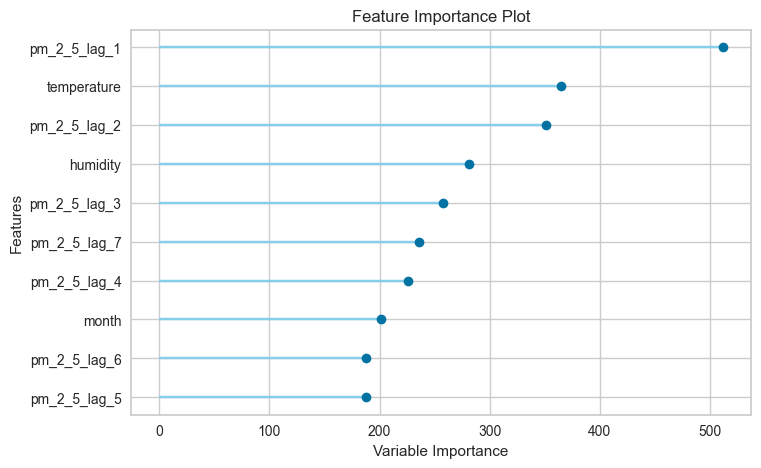

In [73]:
plot_model(best_model, plot='feature')

Extream Case : test by other province data

In [74]:
df_test3 = pd.read_csv("data_preprocess/clean_data/clean_surat.csv", parse_dates=["timestamp"], index_col="timestamp")
df_test3 = df_test3.sort_values(by="timestamp")
df_test3 = df_test3.groupby(['timestamp'], as_index=True).agg({'humidity': 'mean','pm_2_5': 'mean','temperature': 'mean'})
df_test3['dayofweek'] = df_test3.index.dayofweek
df_test3['month'] = df_test3.index.month
df_test3['day'] = df_test3.index.day

In [75]:
# Create lag features for the past 7 days
for lag in range(1, 8):  # Lags from 1 to 7 days
    df_test3[f'pm_2_5_lag_{lag}'] = df_test3['pm_2_5'].shift(lag)

# Drop NaN values caused by shifting
df_test3.dropna(inplace=True)

In [76]:
test_predictions3 = exp.predict_model(best_model, data=df_test3)
test_predictions3

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.9337,29.8754,5.4658,0.8405,0.3238,0.8780


,humidity,temperature,dayofweek,month,day,pm_2_5_lag_1,pm_2_5_lag_2,pm_2_5_lag_3,pm_2_5_lag_4,pm_2_5_lag_5,pm_2_5_lag_6,pm_2_5_lag_7,pm_2_5,prediction_label
timestamp,,,,,,,,,,,,,,
2021-12-01 21:00:00,63.084160,26.532200,2,12,1,1.278689,1.131148,1.133333,1.098361,1.083333,0.815789,2.000000,1.000000,2.870137
2021-12-01 22:00:00,63.969959,26.450001,2,12,1,1.000000,1.278689,1.131148,1.133333,1.098361,1.083333,0.815789,1.000000,2.851827
2021-12-01 23:00:00,63.085220,27.644194,2,12,1,1.000000,1.000000,1.278689,1.131148,1.133333,1.098361,1.083333,1.000000,3.079691
2021-12-02 00:00:00,62.688133,28.375750,3,12,2,1.000000,1.000000,1.000000,1.278689,1.131148,1.133333,1.098361,1.100000,3.056256
2021-12-02 01:00:00,63.037460,28.659153,3,12,2,1.100000,1.000000,1.000000,1.000000,1.278689,1.131148,1.133333,1.406780,2.910458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11 08:00:00,87.340027,23.013561,1,2,11,42.558334,37.806725,34.691666,35.283333,38.275002,36.193275,34.616665,43.263157,44.900904
2025-02-11 09:00:00,80.816277,25.590027,1,2,11,43.263157,42.558334,37.806725,34.691666,35.283333,38.275002,36.193275,42.478992,41.551242
2025-02-11 10:00:00,67.041451,29.023077,1,2,11,42.478992,43.263157,42.558334,37.806725,34.691666,35.283333,38.275002,40.848213,42.160487


วัดจาก mae

In [77]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test3)

# Extract actual values and predicted values
y_true = df_test3["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values  # "prediction_label" contains predictions

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.9337,29.8754,5.4658,0.8405,0.3238,0.8780


R² Score: 0.8405
Mean Absolute Error (MAE): 3.9337
Root Mean Squared Error (RMSE): 5.4658
Accuracy: 83.01%


วัดจาก mape

In [78]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict on the test set
test_predictions = exp.predict_model(best_model, data=df_test3)

# Extract actual values and predicted values
y_true = df_test3["pm_2_5"].values
y_pred = test_predictions["prediction_label"].values

# Filter out zeros from y_true to avoid division by zero in MAPE calculation
non_zero_indices = y_true != 0
y_true_non_zero = y_true[non_zero_indices]
y_pred_non_zero = y_pred[non_zero_indices]

# Calculate Regression Metrics
r2 = r2_score(y_true_non_zero, y_pred_non_zero)
mae = mean_absolute_error(y_true_non_zero, y_pred_non_zero)
rmse = np.sqrt(mean_squared_error(y_true_non_zero, y_pred_non_zero))

# Calculate MAPE and Accuracy for non-zero values
mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,3.9337,29.8754,5.4658,0.8405,0.3238,0.8780


R² Score: 0.8404
Mean Absolute Error (MAE): 3.9323
Root Mean Squared Error (RMSE): 5.4654
Mean Absolute Percentage Error (MAPE): 87.80%
Accuracy: 12.20%


In [79]:
exp.save_model(best_model, 'models/Update_Fisrt_models')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['humidity', 'temperature',
                                              'dayofweek', 'month', 'day',
                                              'pm_2_5_lag_1', 'pm_2_5_lag_2',
                                              'pm_2_5_lag_3', 'pm_2_5_lag_4',
                                              'pm_2_5_lag_5', 'pm_2_5_lag_6',
                                              'pm_2_5_lag_7'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('remove_outliers',
                  TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                 ('trained_model',
                  LGBMRegressor(device='gpu', n_jobs=-1, random_state